In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pprint

import requests
import json
from difflib import get_close_matches
from difflib import SequenceMatcher

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, NMF

plt.style.use('seaborn')

In [2]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
tag_rank_item_matrix = pd.read_csv('data/tag_rank_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')

In [3]:
df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Getting Recommendations

In [4]:
def jaccard_similarity(df):
    return (1 - pairwise_distances(df, metric="jaccard"))


def get_anime_id(search_term):
    id_list = []
    anime_id = title_df[title_df['userPreferred'].isin([search_term])].index
    id_list.append(anime_id)
    
    return id_list[0].values[0]


def get_top_n_recommendations(anime_id, dataframe, similarity_matrix, n=5):
    positional_idx = dataframe.index.get_loc(anime_id)
    
    top_n = np.argsort(similarity_matrix[positional_idx,:])[-n-1:-1]
    recom_titles = []
    for idx, row in title_df.iloc[top_n,:].iterrows():
        if type(row['english']) != float:
            recom_titles.append(row['english'])
        else:
            recom_titles.append(row['userPreferred'])
    
    return recom_titles


def view_title_similarity(search_term, recom_titles):
    for title in recom_titles:
        seq_matcher = SequenceMatcher(None, search_term, title)
        print(f'The terms "{search_term}" and "{title}" are ' 
              + '{0:.2%}'.format(seq_matcher.quick_ratio()) + ' alike.')
        
def get_title_from_id(_id):
    '''Searches the title dataframe based on an anime id and tries to return the english title. 
    If an english title is not available, the "user preferred" is give. '''
    title = None
    if pd.isna(title_df.loc[title_df.index == _id, 'english']).values[0]:
        title = title_df.loc[title_df.index == _id, 'userPreferred'].values[0]
    else:
        title = title_df.loc[title_df.index == _id, 'english'].values[0]
    
    return title


def get_search_term(initial_search):
    '''Search the AniList API for a show based on a query.
    
    Returns the user preferred title 
    '''
    query = '''
    query ($search: String) {
      Media (type: ANIME, search: $search) {
        id
        title {
          romaji
          english
          native
          userPreferred
        }
      }
    }
    '''
    variables = {'search': initial_search}

    url = 'https://graphql.anilist.co'
    response = requests.post(url, 
                             json={'query': query, 
                                   'variables': variables})
    user_preferred_title = response.json()['data']['Media']['title']['userPreferred']

    return user_preferred_title


def view_features(search_term, df):
    _id = title_df[title_df['userPreferred'] == search_term].index
    _df = df.loc[_id,:]

    return list(_df.loc[:, (_df != 0).any(axis=0)].columns)



In [5]:
df_w_rank = pd.concat([genres_item_matrix, tag_rank_item_matrix], axis=1)
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


In [6]:
cos_sim_rank = cosine_similarity(df_w_rank.values)

## PCA

In [7]:
df_w_rank.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.44,0.0,0.0,0.0
99726,0,1,1,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
98526,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
966,0,0,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4876,1,1,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


### With a Standard Scaler

In [8]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)
X_standard_scaled

array([[ 1.65266733, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245,  1.92057355,  1.24756653, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [ 1.65266733, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       ...,
       [-0.60508245, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245, -0.52067779,  1.24756653, ..., -0.0971029 ,
        -0.14614936, -0.06701499],
       [-0.60508245, -0.52067779, -0.80156046, ..., -0.0971029 ,
        -0.14614936, -0.06701499]])

In [9]:
pca_standard_scaled = PCA()
X_pca_standard = pca_standard_scaled.fit_transform(X_standard_scaled)

### Selecting N-Components

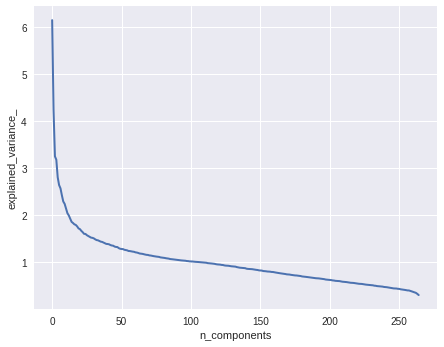

In [12]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_standard_scaled.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_');

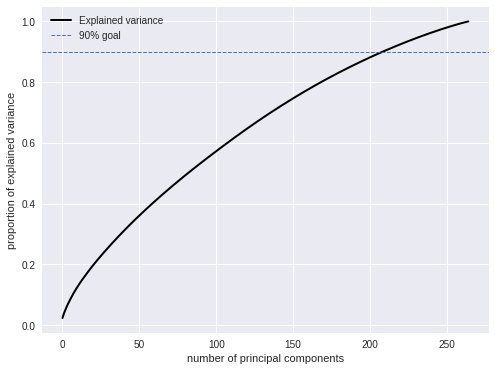

In [13]:
total_variance = np.sum(pca_standard_scaled.explained_variance_)
cum_variance = np.cumsum(pca_standard_scaled.explained_variance_)
prop_var_expl_ss = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl_ss, color = 'black', linewidth=2, label='Explained variance')
ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=1)
ax.set_ylabel('proportion of explained variance')
ax.set_xlabel('number of principal components')
ax.legend()
plt.savefig('images/pca_standard_scaler.png', 
            dpi=96, 
            format='png', 
            transparent=True);

### With a Robust Scaler

In [15]:
X = df_w_rank.to_numpy()

robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X)
X_robust_scaled

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
pca_robust_scaled = PCA()
X_pca_robust = pca_robust_scaled.fit_transform(X_robust_scaled)

### Selecting N-Components

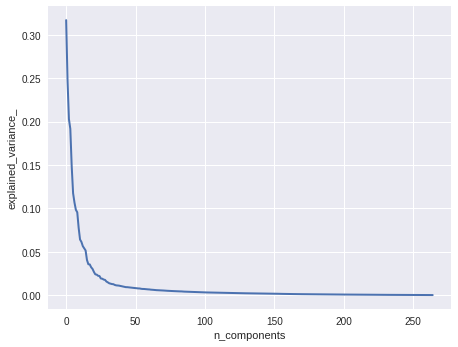

In [19]:
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca_robust_scaled.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_');

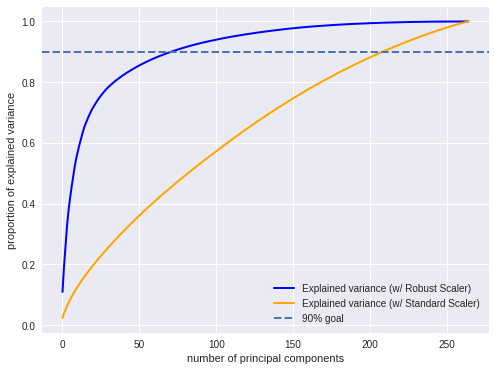

In [20]:
total_variance = np.sum(pca_robust_scaled.explained_variance_)
cum_variance = np.cumsum(pca_robust_scaled.explained_variance_)
prop_var_expl = cum_variance/total_variance

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(prop_var_expl, color = 'blue', linewidth=2, label='Explained variance (w/ Robust Scaler)')
ax.plot(prop_var_expl_ss, color = 'orange', linewidth=2, label='Explained variance (w/ Standard Scaler)')
ax.axhline(0.9, label='90% goal', linestyle='--', linewidth=2)
ax.set_ylabel('proportion of explained variance')
ax.set_xlabel('number of principal components')
ax.legend()
plt.savefig('images/pca_chart.png', 
            dpi=96, 
            format='png', 
            transparent=True);

In [21]:
len(prop_var_expl[prop_var_expl <= 0.9])

71

In [22]:
X = df_w_rank.to_numpy()

robust_scaler = RobustScaler()
X_robust_scaled = robust_scaler.fit_transform(X)


robust_pca = PCA(n_components=71)
X_robust_pca_71pc = robust_pca.fit_transform(X_robust_scaled)

In [23]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)

standard_pca = PCA(n_components=209)
X_standard_pca_209pc = standard_pca.fit_transform(X_standard_scaled)

### Exploring principal components and features

In [24]:
df_robust_pca_71pc = pd.DataFrame(X_robust_pca_71pc, 
                                index=df_w_rank.index)
df_robust_pca_71pc

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
id,,,,,,,,,,,,,,,,,,,,,
10161,0.902054,-0.308564,0.735502,0.421122,0.017534,0.030490,0.243384,0.231924,-0.359572,0.040511,...,-0.097886,0.009885,0.061706,0.119033,0.074712,0.175282,0.052233,-0.074993,0.199321,-0.050308
99726,-0.553772,0.919423,-0.563405,0.693138,0.492470,0.506488,0.254710,-0.667565,0.478517,0.084262,...,0.044597,0.116366,-0.074964,-0.168824,0.097267,0.374512,0.339476,0.103327,-0.510887,0.523914
98526,0.562031,-0.360142,0.285042,0.437012,-0.341345,-0.349305,0.202699,0.012140,-0.634208,-0.074447,...,0.077235,-0.079428,0.067873,-0.092195,-0.004059,-0.137583,-0.030079,0.084170,-0.066282,0.049391
966,-0.947915,0.433247,0.318086,-0.000632,-0.138365,-0.067706,0.449668,-0.391172,0.295403,-0.160393,...,-0.098063,0.220662,-0.139811,-0.151169,0.432365,-0.142261,-0.154499,-0.144422,-0.075883,0.083394
4876,0.893532,0.062809,-0.076532,0.672134,0.141467,-0.872544,0.062129,-0.331749,-0.450992,0.038072,...,0.072844,0.000238,0.135178,0.053865,0.053380,0.104101,0.205656,-0.250938,0.270075,-0.006398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,-0.492690,-0.461529,0.077596,0.035290,-0.218350,0.116027,0.676679,-0.626119,0.378083,-0.271107,...,-0.056127,-0.078489,-0.177871,-0.040188,0.080407,0.054685,0.084423,-0.041317,-0.018533,0.022321
99916,-0.610720,-0.477351,0.175739,0.605864,-0.083200,0.536619,0.216233,-1.029686,0.625074,-0.133925,...,-0.235461,0.035716,-0.022967,-0.044006,-0.268803,-0.138859,-0.010596,0.019822,-0.030456,0.227377
101283,0.072873,-0.510824,-0.055954,0.054418,-0.351963,-0.368537,-0.174323,0.523298,0.773767,0.113512,...,-0.162769,0.133534,0.120694,-0.022693,0.022229,0.306879,-0.183259,0.143332,-0.034833,-0.221981


In [25]:
df_standard_pca_209pc = pd.DataFrame(X_standard_pca_209pc, 
                                index=df_w_rank.index)
df_standard_pca_209pc

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
id,,,,,,,,,,,,,,,,,,,,,
10161,3.063403,-1.639619,-0.071902,-2.650025,1.893117,-1.493811,-0.155653,2.128758,-4.131940,0.067803,...,0.964413,0.581955,-1.418596,0.348990,0.042569,-0.124729,1.658130,-0.872024,1.323114,-0.841255
99726,4.010446,4.335721,-1.888464,1.028603,-1.874806,-2.467711,-5.638975,-6.281735,-8.628402,5.267746,...,2.042935,-0.471074,3.219864,3.300811,-1.368005,-0.463399,1.472313,4.021932,1.402623,-0.877549
98526,-0.184039,-1.841797,-1.663268,-2.009953,-0.619344,-0.506406,0.021354,0.014003,-0.341501,-0.127581,...,0.567890,-0.791818,0.104532,-0.747090,-0.636980,1.099997,-0.258434,0.081908,-0.394843,-0.027383
966,0.115478,2.901496,0.604480,-0.227513,-1.880796,-0.006419,-0.340981,-0.358311,1.775486,1.447963,...,0.826833,0.093991,0.827459,-0.572185,-0.396939,-1.146266,-0.916914,0.217555,-0.860056,-0.854453
4876,2.242231,-2.478053,-0.001131,1.095345,-1.186708,4.356301,3.636356,-2.499803,-0.289060,0.821516,...,1.727983,0.362092,-0.559244,0.646946,-0.301530,-1.380878,-2.461186,1.388541,0.132885,-0.178302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99586,0.931935,5.408326,-0.434780,-2.080132,0.181415,0.904642,-0.536255,0.913400,1.867807,-0.854149,...,-1.821379,3.249455,1.079276,1.315250,0.272049,0.752291,-0.908589,0.558575,1.903865,0.266461
99916,1.312779,5.251961,-1.832626,-2.462061,1.836485,0.335676,1.151863,0.627768,0.054483,-1.188084,...,-1.395545,-1.209322,-1.377279,-0.858152,1.339403,-2.006062,1.130124,1.637189,0.092578,-0.367483
101283,14.639723,-1.381123,8.204788,-2.387346,6.336290,-7.312037,0.315225,4.406702,5.219674,-0.896097,...,-0.343204,-1.740481,-4.432159,1.020070,-4.492290,-5.158115,-1.231373,-3.493805,0.868908,-0.034527


In [26]:
sim_mat_robust_pca = cosine_similarity(df_robust_pca_71pc.values)

In [27]:
sim_mat_standard_pca = cosine_similarity(df_standard_pca_209pc.values)

In [28]:
def view_features_from_id(_id, _df):
    single_show = _df.loc[_id,:]
    
    return set(single_show[single_show != 0].index)



In [29]:
def get_common_tags(list_of_ids):
    list_of_tags = [view_features_from_id(_id, df) for _id in list_of_ids]

    return set.intersection(*list_of_tags)

In [30]:
pc_and_features_robust = pd.DataFrame(robust_pca.components_, columns=df_w_rank.columns)
pc_and_features_robust.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
0,0.551024,0.295329,-0.517596,0.071318,-0.052938,0.162764,0.029915,-0.008734,0.196966,-0.049406,...,0.000365,-0.013993,-0.000130,-0.001023,0.000188,-0.000178,0.000001,-0.002353,-0.007175,0.000731
1,0.306863,0.388868,0.716760,-0.171425,0.096076,0.278198,-0.019124,0.013853,0.010930,-0.242654,...,0.004756,0.004234,0.000140,-0.000936,0.000289,0.001020,0.000704,0.003687,0.001929,0.003099
2,0.251196,-0.334803,0.260712,0.158294,0.065612,-0.598823,-0.007525,-0.029574,0.233905,-0.070830,...,-0.008031,0.008998,0.001413,0.001271,-0.000045,0.002690,0.002162,-0.005519,0.010008,0.001131
3,0.024465,0.063969,-0.049918,0.722560,0.029649,0.229211,0.030808,0.023483,-0.084070,-0.143417,...,0.008607,0.015919,-0.000983,0.005745,0.000397,0.001645,0.006535,0.017395,0.018475,0.002666
4,-0.534272,0.563757,0.042343,0.195306,-0.111869,-0.112769,-0.073641,-0.021528,0.167961,0.003171,...,-0.005310,0.002129,-0.001127,0.000318,0.000064,-0.002210,-0.003515,-0.016341,-0.015443,-0.012880


In [33]:
for idx, vec in pc_and_features_robust.iterrows():
    vec_sorted = vec.sort_values(ascending=False)
    print('Principal Component ', idx)
    print(round(vec_sorted[(vec_sorted > 0.20) | (vec_sorted < -0.20)], 2))

    print('--------------------')

Principal Component  0
action           0.55
sci_fi           0.37
adventure        0.30
slice_of_life   -0.25
comedy          -0.52
Name: 0, dtype: float64
--------------------
Principal Component  1
comedy       0.72
adventure    0.39
action       0.31
fantasy      0.28
music       -0.24
Name: 1, dtype: float64
--------------------
Principal Component  2
sci_fi       0.48
comedy       0.26
action       0.25
mecha        0.23
adventure   -0.33
fantasy     -0.60
Name: 2, dtype: float64
--------------------
Principal Component  3
drama      0.72
romance    0.47
fantasy    0.23
Name: 3, dtype: float64
--------------------
Principal Component  4
adventure       0.56
sci_fi          0.38
supernatural   -0.30
action         -0.53
Name: 4, dtype: float64
--------------------
Principal Component  5
fantasy         0.50
romance         0.39
sci_fi          0.36
drama          -0.25
supernatural   -0.25
adventure      -0.35
Name: 5, dtype: float64
--------------------
Principal Component  6
sli

In [34]:
pp = pprint.PrettyPrinter()
# getting the top titles associated with the first principal components
cut_off = 5
top_n_comps = 50
print(f'Here are the first {top_n_comps} principal components with shows that are good examples and genre/tags that are most common.')
print('--------')
for pc, content in df_robust_pca_71pc.iloc[:,:top_n_comps].items():
    print(f'Principal Component {pc}:')
    top_n_ids = content.sort_values(ascending=False)[:cut_off].index
    pp.pprint([get_title_from_id(_id) for _id in top_n_ids])
    print('-----')

Here are the first 50 principal components with shows that are good examples and genre/tags that are most common.
--------
Principal Component 0:
['Mobile Suit Gundam Wing',
 'Napping Princess',
 'Melody of Oblivion',
 'Mobile Suit Gundam I',
 "Dragon's Heaven"]
-----
Principal Component 1:
['The Seven Deadly Sins',
 'The Familiar of Zero',
 'Dragon Ball Z Movie: Battle of Gods',
 'Fairy Tail Final Season',
 "Dragon Ball Z Movie: Resurrection 'F'"]
-----
Principal Component 2:
['Gurren Lagann',
 'DARLING in the FRANXX',
 'Infinite Stratos',
 'Infinite Stratos 2',
 'Gunbuster']
-----
Principal Component 3:
['Revolutionary Girl Utena',
 "Beyond the Boundary -I'LL BE HERE-: Future",
 'Sugar Sugar Rune',
 'Spirited Away',
 'Clannad']
-----
Principal Component 4:
['Mobile Suit Gundam 0083: Stardust Memory',
 'Brigadoon: Marin to Melan',
 'Eureka Seven',
 'Mobile Suit Gundam: The 08th MS Team',
 'Galaxy Express 999']
-----
Principal Component 5:
['Magical Angel Creamy Mami',
 'Genius Party',

In [ ]:
pc_and_features_standard = pd.DataFrame(standard_pca.components_, columns=df_w_rank.columns)
pc_and_features_standard.head()

In [ ]:
for idx, vec in pc_and_features_standard.iterrows():
    vec_sorted = vec.sort_values(ascending=False)
    print('Principal Component ', idx)
    print(round(vec_sorted[(vec_sorted > 0.10) | (vec_sorted < -0.10)], 2))

    print('--------------------')

In [ ]:
pp = pprint.PrettyPrinter()
# getting the top titles associated with the first principal components
cut_off = 10
top_n_comps = 50
# print(f'Here are the first {top_n_comps} principal components with shows that are good examples and genre/tags that are most common.')
print('--------')
for pc, content in df_standard_pca_209pc.iloc[:,:top_n_comps].items():
    print(f'Principal Component {pc}:')
    top_n_ids = content.sort_values(ascending=False)[:cut_off].index
    pp.pprint([get_title_from_id(_id) for _id in top_n_ids])
    print('-----')

In [ ]:
search_term = get_search_term('Cowboy Bebop')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

In [ ]:
search_term = get_search_term('Dragonball Z')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

In [ ]:
search_term = get_search_term('Attack on Titan')
id_list = get_anime_id(search_term)
rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_robust_pca_71pc, 
                                     sim_mat_robust_pca, 
                                     n=10)
ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                     df_standard_pca_209pc, 
                                     sim_mat_standard_pca, 
                                     n=10)
print('Robust scaler')
pp.pprint(rs_pca_rec_list)
print('-----')
print('Standard scaler')
pp.pprint(ss_pca_rec_list)

The standard scaler does a better job at giving a range of recommended titles but it feels like it sometimes it misses the mark. (I'm surprised a Shin-chan movie was recommended based on "Attack on Titan")  
Also, the robust scaler enabled PCA to get down to a lot less principal components than the standard scaler. 

## NMF

In [ ]:
M = df_w_rank
M

In [ ]:
nmf = NMF(n_components=10)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_
nmf.reconstruction_err_

In [ ]:
W.shape

In [ ]:
H.shape

In [ ]:
def fit_nmf(r):
    nmf = NMF(n_components=r, 
              init='nndsvd', 
              alpha=1)
    nmf.fit(M)
    W = nmf.transform(M)
    H = nmf.components_
    return nmf.reconstruction_err_

_range = 50
error = [fit_nmf(i) for i in range(1,_range)]
plt.plot(range(1,_range), error)
plt.xticks(range(1, _range))
plt.xlabel('r')
plt.ylabel('Reconstruction Errror')

In [ ]:
# reconstruction error for 20 compenents
fit_nmf(50)

In [ ]:
nmf = NMF(n_components=20)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_

In [ ]:
df_topics_to_item = pd.DataFrame(W, index=df_w_rank.index)
df_topics_to_item

In [ ]:
df_topics_to_features = pd.DataFrame(H, columns=df_w_rank.columns)
df_topics_to_features

In [ ]:
for topic in df_topics_to_item.items():
    print('Topic ', topic[0])
    for _id in list(topic[1].sort_values(ascending=False)[:5].index):
        print(get_title_from_id(_id))
    print('-----')

In [ ]:
for topic in df_topics_to_features.iterrows():
    print('Topic', topic[0])
    print(topic[1].sort_values(ascending=False)[:5])
    print('-----')

In [ ]:
M.head()

In [ ]:
df_topics_to_item.head()

## Comparing Everything

In [ ]:
nmf = NMF(n_components=50)
nmf.fit(M)
W = nmf.transform(M)
H = nmf.components_

In [ ]:
X = df_w_rank.to_numpy()

standard_scaler = StandardScaler()
X_standard_scaled = standard_scaler.fit_transform(X)

standard_pca = PCA(n_components=50)
X_standard_pca_50pc = standard_pca.fit_transform(X_standard_scaled)

In [ ]:
df_standard_pca_50pc = pd.DataFrame(X_standard_pca_50pc, 
                                index=df_w_rank.index)

In [ ]:
sim_mat_standard_pca_50pc = cosine_similarity(X_standard_pca_50pc)

In [ ]:
sim_mat_nmf_50comps = cosine_similarity(W)

In [ ]:
df_w_rank

In [ ]:
cos_sim_no_reduc = cosine_similarity(df_w_rank.values)

In [ ]:
sim_mat_standard_pca_209pc = cosine_similarity(df_standard_pca_209pc.values)

In [ ]:
def compare_dim_reducs(anime_title):
    search_term = get_search_term(anime_title)
    id_list = get_anime_id(search_term)
    nmf_rec_list = get_top_n_recommendations(id_list, 
                                         pd.DataFrame(W, index=df_w_rank.index), 
                                         sim_mat_nmf_50comps, 
                                         n=10)
    ss_pca_rec_list = get_top_n_recommendations(id_list, 
                                         df_standard_pca_50pc, 
                                         sim_mat_standard_pca_50pc, 
                                         n=10)
    ss_pca_209pc_rec_list = get_top_n_recommendations(id_list, 
                                         df_standard_pca_209pc, 
                                         sim_mat_standard_pca_209pc, 
                                         n=10)
    rs_pca_rec_list = get_top_n_recommendations(id_list, 
                                         df_robust_pca_71pc, 
                                         sim_mat_robust_pca, 
                                         n=10)
    basic_rec_list = get_top_n_recommendations(id_list, 
                                         df_w_rank, 
                                         cos_sim_no_reduc, 
                                         n=10)
    print('NMF w/ 50 components')
    pp.pprint(nmf_rec_list)
    print('-----')
    print('PCA w/ 50 PCs')
    pp.pprint(ss_pca_rec_list)
    print('-----')
    print('PCA w/ 209 PCs')
    pp.pprint(ss_pca_209pc_rec_list)
    print('-----')
    print('PCA w/ a Robust Scaler and 71 PCs')
    pp.pprint(rs_pca_rec_list)
    print('-----')
    print('No Dimensionality Reduction')
    pp.pprint(basic_rec_list)

In [ ]:
compare_dim_reducs('Dragonball Z')

In [ ]:
compare_dim_reducs('Ergo Proxy')

In [ ]:
compare_dim_reducs('Gangsta')

In [ ]:
compare_dim_reducs('Tokyo Ghoul')

In [ ]:
compare_dim_reducs('Food Wars!')

In [ ]:
compare_dim_reducs('One Punch Man')

<b> Choosing whether to use dimensionality reduction, and then choosing the best technique is proving difficult. The results from all are subjective and usually very similar. Using PCA w/ 209 principal components might be in the lead because it usually is able to provide a variety of recommendations (but sometimes it fails). And if I'm only cutting down my dimensions by 20%, then is it really worth it?  </b>

<b>After further thought, maybe no dimensionality reduction is the way to go for now. A loss in computation speed is not a big deal for this application at this point. It's more valuable to give more accurate recommendations. </b>